# Yelp Reveiw Analysis

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
## standard libs
import pandas as pd
import re
import numpy as np
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
import string
import operator 
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
## cutome modules
from yelp.data import read_json_to_df
from yelp.utils import get_text_lengh
from yelp.utils import target_binning
from yelp.utils import plot_mean_frequency
from yelp.utils import get_bayesian_estimates
from yelp.utils import top_businesses
from yelp.preprocessing import text_clean
from yelp.preprocessing import get_wordcloud
from yelp.preprocessing import tokenize

tqdm.pandas()

%matplotlib inline

## Data

In [66]:
DATA_PATH = '/Users/majidmortazavi/data_sciences/case_studies/NewYorker/data/'
DATA_FILE = 'review.json'

df = read_json_to_df(DATA_PATH, DATA_FILE, chunk_size = 100000)
df.shape

(100000, 9)

In [67]:
df.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg


## Features

In [68]:
df['clean_text'] = df['text'].apply(lambda tx: text_clean(tx))

In [69]:
df = target_binning(df)

In [70]:
df['text_length'] = df['text'].apply(len)
df['clean_text_length'] = df['clean_text'].apply(len)

In [71]:
df.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,clean_text,labels,text_length,clean_text_length
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,Total bill horrible service 8Gs crooks actuall...,Negative,204,121
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,adore Travis Hard Rocks new Kelly Cardenas Sal...,Positive,1561,1046


## EDA

### Text Lenght vs Stars

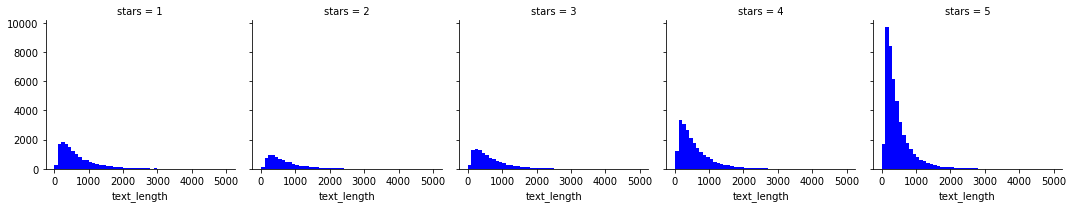

In [72]:
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'text_length',bins=50,color='blue');

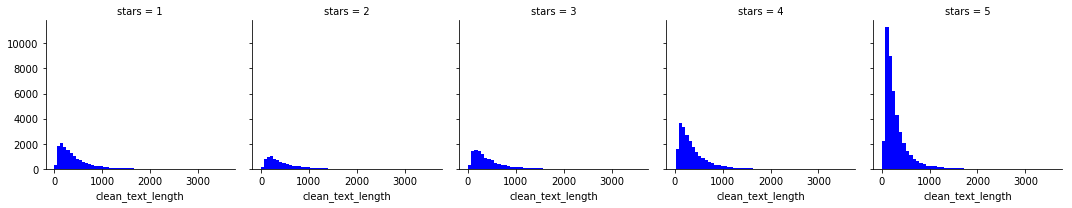

In [73]:
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'clean_text_length',bins=50,color='blue');

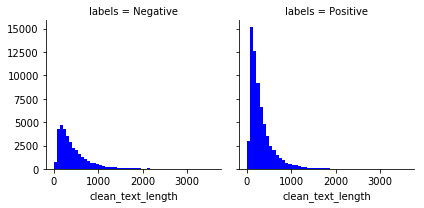

In [81]:
graph = sns.FacetGrid(data=df,col='labels')
graph.map(plt.hist,'clean_text_length',bins=50,color='blue');

### Mean of Variables vs. Stars

In [74]:
eval_cols = ['stars', 'cool','funny', 'useful', 'text_length']
df.groupby('stars')[eval_cols[1:]].mean()

,cool,funny,useful,text_length
stars,,,,
1,0.223792,0.568049,1.949469,736.929379
2,0.390094,0.613166,1.486395,739.896301
3,0.662352,0.574658,1.337192,695.693892
4,0.819798,0.528933,1.315794,609.663032
5,0.510537,0.294994,0.990804,471.914756


In [75]:
eval_cols = ['stars', 'cool','funny', 'useful', 'text_length']
df.groupby('labels')[eval_cols[1:]].mean()

,cool,funny,useful,text_length
labels,,,,
Negative,0.406830,0.580942,1.639010,724.144050
Positive,0.613374,0.372785,1.098872,517.719633


### Correlation of Mean of Variables

In [76]:
eval_cols = ['stars', 'cool','funny', 'useful', 'text_length', 'clean_text_length']
cor_data = df.groupby('stars')[eval_cols[1:]].mean()

cor_data.corr()

,cool,funny,useful,text_length,clean_text_length
cool,1.000000,-0.116468,-0.632180,-0.394650,-0.325124
funny,-0.116468,1.000000,0.691824,0.953699,0.972433
useful,-0.632180,0.691824,1.000000,0.817515,0.784076
text_length,-0.394650,0.953699,0.817515,1.000000,0.997124
clean_text_length,-0.325124,0.972433,0.784076,0.997124,1.000000


### Mean against the Number of Reviews

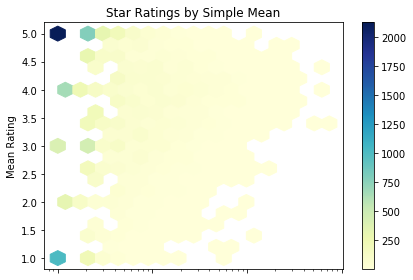

In [77]:
plot_mean_frequency(df)

### Mean, Count and Bayesian Estimation of Stars

In [78]:
top_businesses(df)

,mean,count,bayes
business_id,,,
8mIrX_LrOnAqWsB5JrOojQ,4.429319,191,4.184647
mz9ltimeAIy2c2qf5ctljw,4.381295,278,4.208841
5FIOXmUE3qMviX9GafGH-Q,4.471795,195,4.222449
SUd3IyEN7n5OYEGyt_U5lg,4.698113,106,4.233974
qx6WhZ42eDKmBchZDax4dQ,4.640212,189,4.349372
faPVqws-x-5k2CQKDNtHxw,4.450730,548,4.350334
SVGApDPNdpFlEjwRQThCxA,4.593857,293,4.397959
NCFwm2-TDb-oBQ2medmYDg,4.699482,193,4.401235
qHQPvp6pZ75fB63kOKUPqg,4.980000,100,4.403333


### Stars [1, 5, 4, 3, 2] Histogram

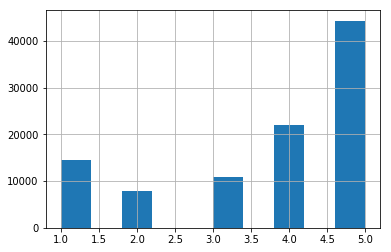

In [79]:
df['stars'].hist();

In [80]:
df['labels'].value_counts()

Positive    66470
Negative    33530
Name: labels, dtype: int64